In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b10','b25','b50','b75'],'fi':['t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_b10_b25_b50_b75_t1_mask_t1_native_k5_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 474)
(631390, 1)
validation
(74368, 474)
(74368, 1)
test
(85358, 474)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 474)]             0         


 dense (Dense)               (None, 1024)              486400    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1175553 (4.48 MB)


Trainable params: 1175553 (4.48 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/64 [..............................] - ETA: 1:30 - loss: 0.0440 - STD: 1.1632e-04 - MAE: 0.1924

 5/64 [=>............................] - ETA: 0s - loss: 0.0229 - STD: 1.8136e-04 - MAE: 0.1183  

 9/64 [===>..........................] - ETA: 0s - loss: 0.0220 - STD: 1.3108e-04 - MAE: 0.1147

13/64 [=====>........................] - ETA: 0s - loss: 0.0189 - STD: 1.0691e-04 - MAE: 0.1042

17/64 [======>.......................] - ETA: 0s - loss: 0.0174 - STD: 1.0002e-04 - MAE: 0.1022

21/64 [========>.....................] - ETA: 0s - loss: 0.0162 - STD: 9.6367e-05 - MAE: 0.0990

24/64 [==========>...................] - ETA: 0s - loss: 0.0155 - STD: 9.3700e-05 - MAE: 0.0961

28/64 [============>.................] - ETA: 0s - loss: 0.0149 - STD: 9.1573e-05 - MAE: 0.0934

32/64 [==============>...............] - ETA: 0s - loss: 0.0143 - STD: 9.2147e-05 - MAE: 0.0913

36/64 [===============>..............] - ETA: 0s - loss: 0.0138 - STD: 9.4685e-05 - MAE: 0.0903

40/64 [=================>............] - ETA: 0s - loss: 0.0134 - STD: 9.7543e-05 - MAE: 0.0893

44/64 [===================>..........] - ETA: 0s - loss: 0.0131 - STD: 9.9923e-05 - MAE: 0.0882

48/64 [=====================>........] - ETA: 0s - loss: 0.0128 - STD: 1.0256e-04 - MAE: 0.0871

52/64 [=======================>......] - ETA: 0s - loss: 0.0126 - STD: 1.0620e-04 - MAE: 0.0864

56/64 [=========================>....] - ETA: 0s - loss: 0.0124 - STD: 1.1059e-04 - MAE: 0.0859

60/64 [===========================>..] - ETA: 0s - loss: 0.0123 - STD: 1.1493e-04 - MAE: 0.0854

64/64 [==============================] - ETA: 0s - loss: 0.0122 - STD: 1.1945e-04 - MAE: 0.0849

64/64 [==============================] - 4s 37ms/step - loss: 0.0122 - STD: 1.1945e-04 - MAE: 0.0849 - val_loss: 0.0094 - val_STD: 1.4015e-04 - val_MAE: 0.0758


Epoch 2/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0098 - STD: 1.9743e-04 - MAE: 0.0768

 5/64 [=>............................] - ETA: 0s - loss: 0.0099 - STD: 2.0747e-04 - MAE: 0.0776

 8/64 [==>...........................] - ETA: 0s - loss: 0.0099 - STD: 2.1461e-04 - MAE: 0.0780

12/64 [====>.........................] - ETA: 0s - loss: 0.0099 - STD: 2.2449e-04 - MAE: 0.0781

16/64 [======>.......................] - ETA: 0s - loss: 0.0099 - STD: 2.3361e-04 - MAE: 0.0779

20/64 [========>.....................] - ETA: 0s - loss: 0.0099 - STD: 2.4319e-04 - MAE: 0.0778

24/64 [==========>...................] - ETA: 0s - loss: 0.0099 - STD: 2.5411e-04 - MAE: 0.0778

28/64 [============>.................] - ETA: 0s - loss: 0.0099 - STD: 2.6561e-04 - MAE: 0.0779

31/64 [=============>................] - ETA: 0s - loss: 0.0099 - STD: 2.7466e-04 - MAE: 0.0779

35/64 [===============>..............] - ETA: 0s - loss: 0.0099 - STD: 2.8723e-04 - MAE: 0.0779

39/64 [=================>............] - ETA: 0s - loss: 0.0099 - STD: 3.0073e-04 - MAE: 0.0779

42/64 [==================>...........] - ETA: 0s - loss: 0.0099 - STD: 3.1209e-04 - MAE: 0.0779

45/64 [====================>.........] - ETA: 0s - loss: 0.0099 - STD: 3.2370e-04 - MAE: 0.0779

49/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 3.3983e-04 - MAE: 0.0778

53/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 3.5734e-04 - MAE: 0.0778

57/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 3.7685e-04 - MAE: 0.0778

61/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 3.9869e-04 - MAE: 0.0778

64/64 [==============================] - 1s 18ms/step - loss: 0.0099 - STD: 4.1565e-04 - MAE: 0.0778 - val_loss: 0.0093 - val_STD: 5.7626e-04 - val_MAE: 0.0759


Epoch 3/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0101 - STD: 7.9221e-04 - MAE: 0.0775

 5/64 [=>............................] - ETA: 0s - loss: 0.0098 - STD: 8.4101e-04 - MAE: 0.0775

 9/64 [===>..........................] - ETA: 0s - loss: 0.0098 - STD: 8.9594e-04 - MAE: 0.0778

13/64 [=====>........................] - ETA: 0s - loss: 0.0099 - STD: 9.4755e-04 - MAE: 0.0778

17/64 [======>.......................] - ETA: 0s - loss: 0.0099 - STD: 0.0010 - MAE: 0.0777    

21/64 [========>.....................] - ETA: 0s - loss: 0.0099 - STD: 0.0011 - MAE: 0.0779

25/64 [==========>...................] - ETA: 0s - loss: 0.0099 - STD: 0.0012 - MAE: 0.0778

29/64 [============>.................] - ETA: 0s - loss: 0.0098 - STD: 0.0012 - MAE: 0.0777

33/64 [==============>...............] - ETA: 0s - loss: 0.0098 - STD: 0.0013 - MAE: 0.0776

37/64 [================>.............] - ETA: 0s - loss: 0.0098 - STD: 0.0014 - MAE: 0.0776

41/64 [==================>...........] - ETA: 0s - loss: 0.0098 - STD: 0.0016 - MAE: 0.0776

45/64 [====================>.........] - ETA: 0s - loss: 0.0098 - STD: 0.0017 - MAE: 0.0776

49/64 [=====================>........] - ETA: 0s - loss: 0.0098 - STD: 0.0019 - MAE: 0.0776

53/64 [=======================>......] - ETA: 0s - loss: 0.0098 - STD: 0.0021 - MAE: 0.0776

56/64 [=========================>....] - ETA: 0s - loss: 0.0098 - STD: 0.0023 - MAE: 0.0776

60/64 [===========================>..] - ETA: 0s - loss: 0.0097 - STD: 0.0025 - MAE: 0.0775

64/64 [==============================] - ETA: 0s - loss: 0.0097 - STD: 0.0029 - MAE: 0.0774

64/64 [==============================] - 1s 18ms/step - loss: 0.0097 - STD: 0.0029 - MAE: 0.0774 - val_loss: 0.0088 - val_STD: 0.0067 - val_MAE: 0.0740


Epoch 4/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0092 - STD: 0.0089 - MAE: 0.0752

 5/64 [=>............................] - ETA: 0s - loss: 0.0092 - STD: 0.0099 - MAE: 0.0752

 9/64 [===>..........................] - ETA: 0s - loss: 0.0092 - STD: 0.0112 - MAE: 0.0757

13/64 [=====>........................] - ETA: 0s - loss: 0.0092 - STD: 0.0125 - MAE: 0.0753

16/64 [======>.......................] - ETA: 0s - loss: 0.0091 - STD: 0.0137 - MAE: 0.0752

20/64 [========>.....................] - ETA: 0s - loss: 0.0090 - STD: 0.0152 - MAE: 0.0748

24/64 [==========>...................] - ETA: 0s - loss: 0.0089 - STD: 0.0169 - MAE: 0.0746

28/64 [============>.................] - ETA: 0s - loss: 0.0089 - STD: 0.0186 - MAE: 0.0745

32/64 [==============>...............] - ETA: 0s - loss: 0.0088 - STD: 0.0202 - MAE: 0.0742

36/64 [===============>..............] - ETA: 0s - loss: 0.0087 - STD: 0.0217 - MAE: 0.0739

40/64 [=================>............] - ETA: 0s - loss: 0.0087 - STD: 0.0232 - MAE: 0.0736

44/64 [===================>..........] - ETA: 0s - loss: 0.0086 - STD: 0.0244 - MAE: 0.0734

48/64 [=====================>........] - ETA: 0s - loss: 0.0086 - STD: 0.0256 - MAE: 0.0731

52/64 [=======================>......] - ETA: 0s - loss: 0.0085 - STD: 0.0266 - MAE: 0.0729

56/64 [=========================>....] - ETA: 0s - loss: 0.0085 - STD: 0.0275 - MAE: 0.0726

60/64 [===========================>..] - ETA: 0s - loss: 0.0084 - STD: 0.0285 - MAE: 0.0723

64/64 [==============================] - ETA: 0s - loss: 0.0084 - STD: 0.0293 - MAE: 0.0720

64/64 [==============================] - 1s 18ms/step - loss: 0.0084 - STD: 0.0293 - MAE: 0.0720 - val_loss: 0.0070 - val_STD: 0.0323 - val_MAE: 0.0648


Epoch 5/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0074 - STD: 0.0428 - MAE: 0.0663

 5/64 [=>............................] - ETA: 0s - loss: 0.0073 - STD: 0.0429 - MAE: 0.0660

 9/64 [===>..........................] - ETA: 0s - loss: 0.0073 - STD: 0.0431 - MAE: 0.0657

13/64 [=====>........................] - ETA: 0s - loss: 0.0073 - STD: 0.0438 - MAE: 0.0656

17/64 [======>.......................] - ETA: 0s - loss: 0.0073 - STD: 0.0446 - MAE: 0.0654

21/64 [========>.....................] - ETA: 0s - loss: 0.0072 - STD: 0.0455 - MAE: 0.0651

25/64 [==========>...................] - ETA: 0s - loss: 0.0072 - STD: 0.0465 - MAE: 0.0649

29/64 [============>.................] - ETA: 0s - loss: 0.0072 - STD: 0.0472 - MAE: 0.0647

32/64 [==============>...............] - ETA: 0s - loss: 0.0071 - STD: 0.0477 - MAE: 0.0645

36/64 [===============>..............] - ETA: 0s - loss: 0.0071 - STD: 0.0483 - MAE: 0.0644

40/64 [=================>............] - ETA: 0s - loss: 0.0071 - STD: 0.0488 - MAE: 0.0642

44/64 [===================>..........] - ETA: 0s - loss: 0.0071 - STD: 0.0492 - MAE: 0.0640

48/64 [=====================>........] - ETA: 0s - loss: 0.0070 - STD: 0.0496 - MAE: 0.0639

52/64 [=======================>......] - ETA: 0s - loss: 0.0070 - STD: 0.0498 - MAE: 0.0637

56/64 [=========================>....] - ETA: 0s - loss: 0.0070 - STD: 0.0502 - MAE: 0.0636

60/64 [===========================>..] - ETA: 0s - loss: 0.0070 - STD: 0.0504 - MAE: 0.0635

64/64 [==============================] - ETA: 0s - loss: 0.0070 - STD: 0.0506 - MAE: 0.0634

64/64 [==============================] - 1s 18ms/step - loss: 0.0070 - STD: 0.0506 - MAE: 0.0634 - val_loss: 0.0060 - val_STD: 0.0413 - val_MAE: 0.0596


Epoch 6/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0066 - STD: 0.0541 - MAE: 0.0617

 4/64 [>.............................] - ETA: 1s - loss: 0.0065 - STD: 0.0543 - MAE: 0.0613

 8/64 [==>...........................] - ETA: 0s - loss: 0.0066 - STD: 0.0541 - MAE: 0.0612

12/64 [====>.........................] - ETA: 0s - loss: 0.0066 - STD: 0.0546 - MAE: 0.0614

16/64 [======>.......................] - ETA: 0s - loss: 0.0066 - STD: 0.0548 - MAE: 0.0613

20/64 [========>.....................] - ETA: 0s - loss: 0.0066 - STD: 0.0552 - MAE: 0.0613

24/64 [==========>...................] - ETA: 0s - loss: 0.0066 - STD: 0.0552 - MAE: 0.0611

27/64 [===========>..................] - ETA: 0s - loss: 0.0066 - STD: 0.0553 - MAE: 0.0612

31/64 [=============>................] - ETA: 0s - loss: 0.0066 - STD: 0.0555 - MAE: 0.0613

35/64 [===============>..............] - ETA: 0s - loss: 0.0066 - STD: 0.0555 - MAE: 0.0612

39/64 [=================>............] - ETA: 0s - loss: 0.0066 - STD: 0.0556 - MAE: 0.0611

43/64 [===================>..........] - ETA: 0s - loss: 0.0066 - STD: 0.0557 - MAE: 0.0610

46/64 [====================>.........] - ETA: 0s - loss: 0.0065 - STD: 0.0558 - MAE: 0.0609

50/64 [======================>.......] - ETA: 0s - loss: 0.0065 - STD: 0.0559 - MAE: 0.0609

54/64 [========================>.....] - ETA: 0s - loss: 0.0065 - STD: 0.0560 - MAE: 0.0608

58/64 [==========================>...] - ETA: 0s - loss: 0.0065 - STD: 0.0561 - MAE: 0.0608

61/64 [===========================>..] - ETA: 0s - loss: 0.0065 - STD: 0.0562 - MAE: 0.0608

64/64 [==============================] - 1s 18ms/step - loss: 0.0065 - STD: 0.0563 - MAE: 0.0607 - val_loss: 0.0058 - val_STD: 0.0447 - val_MAE: 0.0585


Epoch 7/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0064 - STD: 0.0590 - MAE: 0.0610

 4/64 [>.............................] - ETA: 1s - loss: 0.0063 - STD: 0.0580 - MAE: 0.0599

 8/64 [==>...........................] - ETA: 0s - loss: 0.0063 - STD: 0.0580 - MAE: 0.0599

11/64 [====>.........................] - ETA: 0s - loss: 0.0063 - STD: 0.0579 - MAE: 0.0598

14/64 [=====>........................] - ETA: 0s - loss: 0.0063 - STD: 0.0579 - MAE: 0.0598

17/64 [======>.......................] - ETA: 0s - loss: 0.0063 - STD: 0.0579 - MAE: 0.0598

20/64 [========>.....................] - ETA: 0s - loss: 0.0064 - STD: 0.0580 - MAE: 0.0600

23/64 [=========>....................] - ETA: 0s - loss: 0.0064 - STD: 0.0579 - MAE: 0.0600

26/64 [===========>..................] - ETA: 0s - loss: 0.0064 - STD: 0.0578 - MAE: 0.0601

30/64 [=============>................] - ETA: 0s - loss: 0.0064 - STD: 0.0577 - MAE: 0.0600

34/64 [==============>...............] - ETA: 0s - loss: 0.0064 - STD: 0.0577 - MAE: 0.0600

38/64 [================>.............] - ETA: 0s - loss: 0.0064 - STD: 0.0577 - MAE: 0.0600

41/64 [==================>...........] - ETA: 0s - loss: 0.0064 - STD: 0.0578 - MAE: 0.0599

44/64 [===================>..........] - ETA: 0s - loss: 0.0064 - STD: 0.0579 - MAE: 0.0599

48/64 [=====================>........] - ETA: 0s - loss: 0.0064 - STD: 0.0581 - MAE: 0.0599

52/64 [=======================>......] - ETA: 0s - loss: 0.0064 - STD: 0.0582 - MAE: 0.0598

56/64 [=========================>....] - ETA: 0s - loss: 0.0064 - STD: 0.0583 - MAE: 0.0598

60/64 [===========================>..] - ETA: 0s - loss: 0.0063 - STD: 0.0584 - MAE: 0.0598

64/64 [==============================] - ETA: 0s - loss: 0.0063 - STD: 0.0584 - MAE: 0.0597

64/64 [==============================] - 1s 19ms/step - loss: 0.0063 - STD: 0.0584 - MAE: 0.0597 - val_loss: 0.0056 - val_STD: 0.0458 - val_MAE: 0.0573


Epoch 8/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0063 - STD: 0.0595 - MAE: 0.0601

 5/64 [=>............................] - ETA: 0s - loss: 0.0063 - STD: 0.0587 - MAE: 0.0595

 9/64 [===>..........................] - ETA: 0s - loss: 0.0063 - STD: 0.0586 - MAE: 0.0592

13/64 [=====>........................] - ETA: 0s - loss: 0.0063 - STD: 0.0587 - MAE: 0.0593

17/64 [======>.......................] - ETA: 0s - loss: 0.0062 - STD: 0.0588 - MAE: 0.0592

21/64 [========>.....................] - ETA: 0s - loss: 0.0062 - STD: 0.0589 - MAE: 0.0591

24/64 [==========>...................] - ETA: 0s - loss: 0.0063 - STD: 0.0591 - MAE: 0.0594

27/64 [===========>..................] - ETA: 0s - loss: 0.0063 - STD: 0.0592 - MAE: 0.0593

31/64 [=============>................] - ETA: 0s - loss: 0.0063 - STD: 0.0592 - MAE: 0.0592

35/64 [===============>..............] - ETA: 0s - loss: 0.0062 - STD: 0.0592 - MAE: 0.0592

38/64 [================>.............] - ETA: 0s - loss: 0.0062 - STD: 0.0592 - MAE: 0.0592

42/64 [==================>...........] - ETA: 0s - loss: 0.0062 - STD: 0.0592 - MAE: 0.0591

45/64 [====================>.........] - ETA: 0s - loss: 0.0062 - STD: 0.0592 - MAE: 0.0591

48/64 [=====================>........] - ETA: 0s - loss: 0.0062 - STD: 0.0593 - MAE: 0.0591

51/64 [======================>.......] - ETA: 0s - loss: 0.0062 - STD: 0.0594 - MAE: 0.0591

54/64 [========================>.....] - ETA: 0s - loss: 0.0062 - STD: 0.0594 - MAE: 0.0590

58/64 [==========================>...] - ETA: 0s - loss: 0.0062 - STD: 0.0595 - MAE: 0.0591

62/64 [============================>.] - ETA: 0s - loss: 0.0062 - STD: 0.0596 - MAE: 0.0590

64/64 [==============================] - 1s 19ms/step - loss: 0.0062 - STD: 0.0596 - MAE: 0.0590 - val_loss: 0.0055 - val_STD: 0.0472 - val_MAE: 0.0563


Epoch 9/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0062 - STD: 0.0609 - MAE: 0.0595

 4/64 [>.............................] - ETA: 1s - loss: 0.0064 - STD: 0.0604 - MAE: 0.0602

 7/64 [==>...........................] - ETA: 0s - loss: 0.0063 - STD: 0.0601 - MAE: 0.0597

11/64 [====>.........................] - ETA: 0s - loss: 0.0064 - STD: 0.0596 - MAE: 0.0598

14/64 [=====>........................] - ETA: 0s - loss: 0.0063 - STD: 0.0594 - MAE: 0.0595

17/64 [======>.......................] - ETA: 0s - loss: 0.0063 - STD: 0.0593 - MAE: 0.0595

21/64 [========>.....................] - ETA: 0s - loss: 0.0063 - STD: 0.0592 - MAE: 0.0594

25/64 [==========>...................] - ETA: 0s - loss: 0.0062 - STD: 0.0592 - MAE: 0.0591

29/64 [============>.................] - ETA: 0s - loss: 0.0062 - STD: 0.0594 - MAE: 0.0591

33/64 [==============>...............] - ETA: 0s - loss: 0.0062 - STD: 0.0595 - MAE: 0.0589

36/64 [===============>..............] - ETA: 0s - loss: 0.0062 - STD: 0.0596 - MAE: 0.0589

39/64 [=================>............] - ETA: 0s - loss: 0.0062 - STD: 0.0598 - MAE: 0.0589

43/64 [===================>..........] - ETA: 0s - loss: 0.0062 - STD: 0.0598 - MAE: 0.0588

47/64 [=====================>........] - ETA: 0s - loss: 0.0062 - STD: 0.0599 - MAE: 0.0588

51/64 [======================>.......] - ETA: 0s - loss: 0.0062 - STD: 0.0600 - MAE: 0.0588

55/64 [========================>.....] - ETA: 0s - loss: 0.0062 - STD: 0.0600 - MAE: 0.0588

59/64 [==========================>...] - ETA: 0s - loss: 0.0062 - STD: 0.0600 - MAE: 0.0588

63/64 [============================>.] - ETA: 0s - loss: 0.0062 - STD: 0.0600 - MAE: 0.0587

64/64 [==============================] - 1s 18ms/step - loss: 0.0062 - STD: 0.0601 - MAE: 0.0587 - val_loss: 0.0056 - val_STD: 0.0469 - val_MAE: 0.0555


Epoch 10/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0061 - STD: 0.0604 - MAE: 0.0577

 5/64 [=>............................] - ETA: 0s - loss: 0.0061 - STD: 0.0610 - MAE: 0.0583

 8/64 [==>...........................] - ETA: 0s - loss: 0.0061 - STD: 0.0611 - MAE: 0.0586

12/64 [====>.........................] - ETA: 0s - loss: 0.0061 - STD: 0.0612 - MAE: 0.0582

16/64 [======>.......................] - ETA: 0s - loss: 0.0061 - STD: 0.0612 - MAE: 0.0582

19/64 [=======>......................] - ETA: 0s - loss: 0.0061 - STD: 0.0613 - MAE: 0.0581

23/64 [=========>....................] - ETA: 0s - loss: 0.0061 - STD: 0.0612 - MAE: 0.0582

27/64 [===========>..................] - ETA: 0s - loss: 0.0061 - STD: 0.0613 - MAE: 0.0582

30/64 [=============>................] - ETA: 0s - loss: 0.0061 - STD: 0.0612 - MAE: 0.0582

33/64 [==============>...............] - ETA: 0s - loss: 0.0061 - STD: 0.0612 - MAE: 0.0583

36/64 [===============>..............] - ETA: 0s - loss: 0.0061 - STD: 0.0612 - MAE: 0.0583

39/64 [=================>............] - ETA: 0s - loss: 0.0061 - STD: 0.0611 - MAE: 0.0582

42/64 [==================>...........] - ETA: 0s - loss: 0.0061 - STD: 0.0612 - MAE: 0.0582

45/64 [====================>.........] - ETA: 0s - loss: 0.0061 - STD: 0.0612 - MAE: 0.0583

48/64 [=====================>........] - ETA: 0s - loss: 0.0061 - STD: 0.0611 - MAE: 0.0583

52/64 [=======================>......] - ETA: 0s - loss: 0.0061 - STD: 0.0611 - MAE: 0.0582

55/64 [========================>.....] - ETA: 0s - loss: 0.0061 - STD: 0.0611 - MAE: 0.0581

58/64 [==========================>...] - ETA: 0s - loss: 0.0061 - STD: 0.0611 - MAE: 0.0581

61/64 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.0611 - MAE: 0.0581

64/64 [==============================] - ETA: 0s - loss: 0.0061 - STD: 0.0611 - MAE: 0.0581

64/64 [==============================] - 1s 19ms/step - loss: 0.0061 - STD: 0.0611 - MAE: 0.0581 - val_loss: 0.0054 - val_STD: 0.0500 - val_MAE: 0.0559


Epoch 11/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0060 - STD: 0.0631 - MAE: 0.0585

 4/64 [>.............................] - ETA: 1s - loss: 0.0061 - STD: 0.0612 - MAE: 0.0581

 8/64 [==>...........................] - ETA: 0s - loss: 0.0061 - STD: 0.0614 - MAE: 0.0582

12/64 [====>.........................] - ETA: 0s - loss: 0.0061 - STD: 0.0611 - MAE: 0.0580

16/64 [======>.......................] - ETA: 0s - loss: 0.0061 - STD: 0.0613 - MAE: 0.0582

19/64 [=======>......................] - ETA: 0s - loss: 0.0061 - STD: 0.0612 - MAE: 0.0582

22/64 [=========>....................] - ETA: 0s - loss: 0.0061 - STD: 0.0611 - MAE: 0.0582

26/64 [===========>..................] - ETA: 0s - loss: 0.0061 - STD: 0.0611 - MAE: 0.0582

30/64 [=============>................] - ETA: 0s - loss: 0.0061 - STD: 0.0612 - MAE: 0.0582

33/64 [==============>...............] - ETA: 0s - loss: 0.0061 - STD: 0.0612 - MAE: 0.0581

37/64 [================>.............] - ETA: 0s - loss: 0.0060 - STD: 0.0613 - MAE: 0.0580

41/64 [==================>...........] - ETA: 0s - loss: 0.0060 - STD: 0.0614 - MAE: 0.0579

45/64 [====================>.........] - ETA: 0s - loss: 0.0060 - STD: 0.0615 - MAE: 0.0579

49/64 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0616 - MAE: 0.0579

53/64 [=======================>......] - ETA: 0s - loss: 0.0060 - STD: 0.0617 - MAE: 0.0579

57/64 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0617 - MAE: 0.0579

61/64 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0617 - MAE: 0.0579

64/64 [==============================] - 1s 18ms/step - loss: 0.0060 - STD: 0.0617 - MAE: 0.0580 - val_loss: 0.0053 - val_STD: 0.0494 - val_MAE: 0.0553


Epoch 12/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0058 - STD: 0.0611 - MAE: 0.0575

 4/64 [>.............................] - ETA: 1s - loss: 0.0061 - STD: 0.0598 - MAE: 0.0583

 8/64 [==>...........................] - ETA: 0s - loss: 0.0061 - STD: 0.0595 - MAE: 0.0581

11/64 [====>.........................] - ETA: 0s - loss: 0.0060 - STD: 0.0594 - MAE: 0.0579

14/64 [=====>........................] - ETA: 0s - loss: 0.0060 - STD: 0.0596 - MAE: 0.0580

17/64 [======>.......................] - ETA: 0s - loss: 0.0060 - STD: 0.0598 - MAE: 0.0580

20/64 [========>.....................] - ETA: 0s - loss: 0.0060 - STD: 0.0600 - MAE: 0.0580

24/64 [==========>...................] - ETA: 0s - loss: 0.0060 - STD: 0.0603 - MAE: 0.0578

27/64 [===========>..................] - ETA: 0s - loss: 0.0060 - STD: 0.0605 - MAE: 0.0578

31/64 [=============>................] - ETA: 0s - loss: 0.0060 - STD: 0.0608 - MAE: 0.0577

34/64 [==============>...............] - ETA: 0s - loss: 0.0060 - STD: 0.0610 - MAE: 0.0577

37/64 [================>.............] - ETA: 0s - loss: 0.0060 - STD: 0.0612 - MAE: 0.0577

40/64 [=================>............] - ETA: 0s - loss: 0.0060 - STD: 0.0612 - MAE: 0.0577

44/64 [===================>..........] - ETA: 0s - loss: 0.0060 - STD: 0.0614 - MAE: 0.0577

47/64 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0614 - MAE: 0.0577

50/64 [======================>.......] - ETA: 0s - loss: 0.0060 - STD: 0.0614 - MAE: 0.0577

53/64 [=======================>......] - ETA: 0s - loss: 0.0060 - STD: 0.0615 - MAE: 0.0577

56/64 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0616 - MAE: 0.0577

59/64 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.0616 - MAE: 0.0576

62/64 [============================>.] - ETA: 0s - loss: 0.0060 - STD: 0.0616 - MAE: 0.0576

64/64 [==============================] - 1s 19ms/step - loss: 0.0060 - STD: 0.0617 - MAE: 0.0576 - val_loss: 0.0063 - val_STD: 0.0464 - val_MAE: 0.0573


Epoch 13/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0064 - STD: 0.0592 - MAE: 0.0571

 4/64 [>.............................] - ETA: 1s - loss: 0.0061 - STD: 0.0625 - MAE: 0.0577

 7/64 [==>...........................] - ETA: 0s - loss: 0.0060 - STD: 0.0627 - MAE: 0.0574

10/64 [===>..........................] - ETA: 0s - loss: 0.0059 - STD: 0.0625 - MAE: 0.0572

13/64 [=====>........................] - ETA: 0s - loss: 0.0060 - STD: 0.0624 - MAE: 0.0573

16/64 [======>.......................] - ETA: 0s - loss: 0.0060 - STD: 0.0623 - MAE: 0.0573

20/64 [========>.....................] - ETA: 0s - loss: 0.0060 - STD: 0.0624 - MAE: 0.0573

24/64 [==========>...................] - ETA: 0s - loss: 0.0060 - STD: 0.0622 - MAE: 0.0576

27/64 [===========>..................] - ETA: 0s - loss: 0.0060 - STD: 0.0622 - MAE: 0.0576

30/64 [=============>................] - ETA: 0s - loss: 0.0060 - STD: 0.0621 - MAE: 0.0576

33/64 [==============>...............] - ETA: 0s - loss: 0.0060 - STD: 0.0621 - MAE: 0.0577

36/64 [===============>..............] - ETA: 0s - loss: 0.0060 - STD: 0.0619 - MAE: 0.0576

39/64 [=================>............] - ETA: 0s - loss: 0.0060 - STD: 0.0618 - MAE: 0.0577

42/64 [==================>...........] - ETA: 0s - loss: 0.0060 - STD: 0.0618 - MAE: 0.0576

45/64 [====================>.........] - ETA: 0s - loss: 0.0060 - STD: 0.0618 - MAE: 0.0576

49/64 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0620 - MAE: 0.0575

53/64 [=======================>......] - ETA: 0s - loss: 0.0060 - STD: 0.0621 - MAE: 0.0575

57/64 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0622 - MAE: 0.0575

61/64 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0622 - MAE: 0.0576

64/64 [==============================] - 1s 18ms/step - loss: 0.0060 - STD: 0.0622 - MAE: 0.0576 - val_loss: 0.0054 - val_STD: 0.0542 - val_MAE: 0.0580


Epoch 14/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0064 - STD: 0.0693 - MAE: 0.0626

 4/64 [>.............................] - ETA: 1s - loss: 0.0062 - STD: 0.0628 - MAE: 0.0597

 7/64 [==>...........................] - ETA: 1s - loss: 0.0062 - STD: 0.0614 - MAE: 0.0594

10/64 [===>..........................] - ETA: 0s - loss: 0.0063 - STD: 0.0607 - MAE: 0.0599

14/64 [=====>........................] - ETA: 0s - loss: 0.0064 - STD: 0.0596 - MAE: 0.0600

18/64 [=======>......................] - ETA: 0s - loss: 0.0064 - STD: 0.0588 - MAE: 0.0598

22/64 [=========>....................] - ETA: 0s - loss: 0.0064 - STD: 0.0584 - MAE: 0.0596

26/64 [===========>..................] - ETA: 0s - loss: 0.0063 - STD: 0.0582 - MAE: 0.0594

29/64 [============>.................] - ETA: 0s - loss: 0.0063 - STD: 0.0583 - MAE: 0.0592

33/64 [==============>...............] - ETA: 0s - loss: 0.0062 - STD: 0.0585 - MAE: 0.0591

36/64 [===============>..............] - ETA: 0s - loss: 0.0062 - STD: 0.0588 - MAE: 0.0589

40/64 [=================>............] - ETA: 0s - loss: 0.0062 - STD: 0.0592 - MAE: 0.0588

44/64 [===================>..........] - ETA: 0s - loss: 0.0062 - STD: 0.0596 - MAE: 0.0587

47/64 [=====================>........] - ETA: 0s - loss: 0.0061 - STD: 0.0598 - MAE: 0.0586

50/64 [======================>.......] - ETA: 0s - loss: 0.0061 - STD: 0.0600 - MAE: 0.0585

54/64 [========================>.....] - ETA: 0s - loss: 0.0061 - STD: 0.0602 - MAE: 0.0583

57/64 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0604 - MAE: 0.0582

60/64 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.0606 - MAE: 0.0582

64/64 [==============================] - ETA: 0s - loss: 0.0061 - STD: 0.0607 - MAE: 0.0581

64/64 [==============================] - 1s 19ms/step - loss: 0.0061 - STD: 0.0607 - MAE: 0.0581 - val_loss: 0.0053 - val_STD: 0.0522 - val_MAE: 0.0552


Epoch 15/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0060 - STD: 0.0648 - MAE: 0.0581

 4/64 [>.............................] - ETA: 1s - loss: 0.0059 - STD: 0.0631 - MAE: 0.0570

 7/64 [==>...........................] - ETA: 0s - loss: 0.0058 - STD: 0.0630 - MAE: 0.0569

10/64 [===>..........................] - ETA: 0s - loss: 0.0058 - STD: 0.0630 - MAE: 0.0569

13/64 [=====>........................] - ETA: 0s - loss: 0.0058 - STD: 0.0630 - MAE: 0.0569

16/64 [======>.......................] - ETA: 0s - loss: 0.0058 - STD: 0.0630 - MAE: 0.0569

19/64 [=======>......................] - ETA: 0s - loss: 0.0058 - STD: 0.0630 - MAE: 0.0569

22/64 [=========>....................] - ETA: 0s - loss: 0.0058 - STD: 0.0631 - MAE: 0.0569

25/64 [==========>...................] - ETA: 0s - loss: 0.0059 - STD: 0.0631 - MAE: 0.0570

28/64 [============>.................] - ETA: 0s - loss: 0.0058 - STD: 0.0632 - MAE: 0.0570

31/64 [=============>................] - ETA: 0s - loss: 0.0058 - STD: 0.0631 - MAE: 0.0569

34/64 [==============>...............] - ETA: 0s - loss: 0.0058 - STD: 0.0631 - MAE: 0.0569

37/64 [================>.............] - ETA: 0s - loss: 0.0058 - STD: 0.0631 - MAE: 0.0568

40/64 [=================>............] - ETA: 0s - loss: 0.0058 - STD: 0.0631 - MAE: 0.0569

43/64 [===================>..........] - ETA: 0s - loss: 0.0058 - STD: 0.0632 - MAE: 0.0569

47/64 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0632 - MAE: 0.0568

50/64 [======================>.......] - ETA: 0s - loss: 0.0058 - STD: 0.0632 - MAE: 0.0569

53/64 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0633 - MAE: 0.0569

56/64 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.0633 - MAE: 0.0569

59/64 [==========================>...] - ETA: 0s - loss: 0.0059 - STD: 0.0632 - MAE: 0.0570

62/64 [============================>.] - ETA: 0s - loss: 0.0059 - STD: 0.0632 - MAE: 0.0570

64/64 [==============================] - 1s 19ms/step - loss: 0.0059 - STD: 0.0632 - MAE: 0.0570 - val_loss: 0.0053 - val_STD: 0.0520 - val_MAE: 0.0549


Epoch 16/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0059 - STD: 0.0643 - MAE: 0.0576

 4/64 [>.............................] - ETA: 1s - loss: 0.0059 - STD: 0.0634 - MAE: 0.0570

 7/64 [==>...........................] - ETA: 1s - loss: 0.0059 - STD: 0.0632 - MAE: 0.0570

10/64 [===>..........................] - ETA: 0s - loss: 0.0058 - STD: 0.0632 - MAE: 0.0569

13/64 [=====>........................] - ETA: 0s - loss: 0.0059 - STD: 0.0632 - MAE: 0.0569

16/64 [======>.......................] - ETA: 0s - loss: 0.0059 - STD: 0.0633 - MAE: 0.0569

19/64 [=======>......................] - ETA: 0s - loss: 0.0058 - STD: 0.0635 - MAE: 0.0568

22/64 [=========>....................] - ETA: 0s - loss: 0.0058 - STD: 0.0635 - MAE: 0.0569

25/64 [==========>...................] - ETA: 0s - loss: 0.0058 - STD: 0.0636 - MAE: 0.0569

29/64 [============>.................] - ETA: 0s - loss: 0.0058 - STD: 0.0636 - MAE: 0.0568

32/64 [==============>...............] - ETA: 0s - loss: 0.0058 - STD: 0.0635 - MAE: 0.0568

35/64 [===============>..............] - ETA: 0s - loss: 0.0058 - STD: 0.0635 - MAE: 0.0568

38/64 [================>.............] - ETA: 0s - loss: 0.0058 - STD: 0.0635 - MAE: 0.0568

41/64 [==================>...........] - ETA: 0s - loss: 0.0058 - STD: 0.0634 - MAE: 0.0569

44/64 [===================>..........] - ETA: 0s - loss: 0.0058 - STD: 0.0634 - MAE: 0.0569

47/64 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0634 - MAE: 0.0569

50/64 [======================>.......] - ETA: 0s - loss: 0.0058 - STD: 0.0634 - MAE: 0.0569

53/64 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0633 - MAE: 0.0569

56/64 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0633 - MAE: 0.0569

59/64 [==========================>...] - ETA: 0s - loss: 0.0058 - STD: 0.0633 - MAE: 0.0569

62/64 [============================>.] - ETA: 0s - loss: 0.0058 - STD: 0.0633 - MAE: 0.0569

64/64 [==============================] - 1s 19ms/step - loss: 0.0058 - STD: 0.0633 - MAE: 0.0569 - val_loss: 0.0057 - val_STD: 0.0498 - val_MAE: 0.0555


Epoch 17/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0057 - STD: 0.0609 - MAE: 0.0555

 4/64 [>.............................] - ETA: 1s - loss: 0.0058 - STD: 0.0627 - MAE: 0.0562

 7/64 [==>...........................] - ETA: 0s - loss: 0.0058 - STD: 0.0633 - MAE: 0.0564

10/64 [===>..........................] - ETA: 0s - loss: 0.0058 - STD: 0.0633 - MAE: 0.0566

13/64 [=====>........................] - ETA: 0s - loss: 0.0058 - STD: 0.0635 - MAE: 0.0566

16/64 [======>.......................] - ETA: 0s - loss: 0.0058 - STD: 0.0637 - MAE: 0.0567

19/64 [=======>......................] - ETA: 0s - loss: 0.0058 - STD: 0.0636 - MAE: 0.0567

22/64 [=========>....................] - ETA: 0s - loss: 0.0058 - STD: 0.0635 - MAE: 0.0567

25/64 [==========>...................] - ETA: 0s - loss: 0.0058 - STD: 0.0635 - MAE: 0.0567

28/64 [============>.................] - ETA: 0s - loss: 0.0058 - STD: 0.0635 - MAE: 0.0568

31/64 [=============>................] - ETA: 0s - loss: 0.0058 - STD: 0.0636 - MAE: 0.0568

35/64 [===============>..............] - ETA: 0s - loss: 0.0058 - STD: 0.0633 - MAE: 0.0568

39/64 [=================>............] - ETA: 0s - loss: 0.0058 - STD: 0.0634 - MAE: 0.0569

42/64 [==================>...........] - ETA: 0s - loss: 0.0058 - STD: 0.0633 - MAE: 0.0568

45/64 [====================>.........] - ETA: 0s - loss: 0.0058 - STD: 0.0633 - MAE: 0.0568

49/64 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0632 - MAE: 0.0569

53/64 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0632 - MAE: 0.0569

57/64 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.0632 - MAE: 0.0569

61/64 [===========================>..] - ETA: 0s - loss: 0.0058 - STD: 0.0632 - MAE: 0.0569

64/64 [==============================] - ETA: 0s - loss: 0.0058 - STD: 0.0633 - MAE: 0.0569

64/64 [==============================] - 1s 18ms/step - loss: 0.0058 - STD: 0.0633 - MAE: 0.0569 - val_loss: 0.0055 - val_STD: 0.0510 - val_MAE: 0.0552


Epoch 18/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0060 - STD: 0.0629 - MAE: 0.0565

 4/64 [>.............................] - ETA: 1s - loss: 0.0063 - STD: 0.0634 - MAE: 0.0591

 7/64 [==>...........................] - ETA: 0s - loss: 0.0063 - STD: 0.0627 - MAE: 0.0589

10/64 [===>..........................] - ETA: 0s - loss: 0.0063 - STD: 0.0616 - MAE: 0.0592

13/64 [=====>........................] - ETA: 0s - loss: 0.0064 - STD: 0.0606 - MAE: 0.0594

17/64 [======>.......................] - ETA: 0s - loss: 0.0064 - STD: 0.0597 - MAE: 0.0599

20/64 [========>.....................] - ETA: 0s - loss: 0.0064 - STD: 0.0589 - MAE: 0.0597

23/64 [=========>....................] - ETA: 0s - loss: 0.0064 - STD: 0.0585 - MAE: 0.0596

26/64 [===========>..................] - ETA: 0s - loss: 0.0063 - STD: 0.0585 - MAE: 0.0594

30/64 [=============>................] - ETA: 0s - loss: 0.0063 - STD: 0.0585 - MAE: 0.0592

33/64 [==============>...............] - ETA: 0s - loss: 0.0062 - STD: 0.0589 - MAE: 0.0590

36/64 [===============>..............] - ETA: 0s - loss: 0.0062 - STD: 0.0593 - MAE: 0.0588

40/64 [=================>............] - ETA: 0s - loss: 0.0062 - STD: 0.0597 - MAE: 0.0586

43/64 [===================>..........] - ETA: 0s - loss: 0.0062 - STD: 0.0601 - MAE: 0.0586

47/64 [=====================>........] - ETA: 0s - loss: 0.0061 - STD: 0.0604 - MAE: 0.0584

51/64 [======================>.......] - ETA: 0s - loss: 0.0061 - STD: 0.0607 - MAE: 0.0583

54/64 [========================>.....] - ETA: 0s - loss: 0.0061 - STD: 0.0608 - MAE: 0.0582

58/64 [==========================>...] - ETA: 0s - loss: 0.0061 - STD: 0.0609 - MAE: 0.0582

62/64 [============================>.] - ETA: 0s - loss: 0.0061 - STD: 0.0610 - MAE: 0.0581

64/64 [==============================] - 1s 19ms/step - loss: 0.0061 - STD: 0.0610 - MAE: 0.0580 - val_loss: 0.0052 - val_STD: 0.0527 - val_MAE: 0.0555


Epoch 19/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0059 - STD: 0.0647 - MAE: 0.0589

 4/64 [>.............................] - ETA: 1s - loss: 0.0058 - STD: 0.0619 - MAE: 0.0570

 7/64 [==>...........................] - ETA: 0s - loss: 0.0058 - STD: 0.0616 - MAE: 0.0570

10/64 [===>..........................] - ETA: 0s - loss: 0.0058 - STD: 0.0618 - MAE: 0.0569

14/64 [=====>........................] - ETA: 0s - loss: 0.0058 - STD: 0.0620 - MAE: 0.0570

18/64 [=======>......................] - ETA: 0s - loss: 0.0058 - STD: 0.0622 - MAE: 0.0571

22/64 [=========>....................] - ETA: 0s - loss: 0.0058 - STD: 0.0622 - MAE: 0.0570

26/64 [===========>..................] - ETA: 0s - loss: 0.0059 - STD: 0.0622 - MAE: 0.0570

29/64 [============>.................] - ETA: 0s - loss: 0.0059 - STD: 0.0623 - MAE: 0.0570

32/64 [==============>...............] - ETA: 0s - loss: 0.0058 - STD: 0.0624 - MAE: 0.0570

36/64 [===============>..............] - ETA: 0s - loss: 0.0058 - STD: 0.0624 - MAE: 0.0568

40/64 [=================>............] - ETA: 0s - loss: 0.0058 - STD: 0.0626 - MAE: 0.0568

43/64 [===================>..........] - ETA: 0s - loss: 0.0058 - STD: 0.0627 - MAE: 0.0568

46/64 [====================>.........] - ETA: 0s - loss: 0.0058 - STD: 0.0627 - MAE: 0.0568

49/64 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0628 - MAE: 0.0568

53/64 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0630 - MAE: 0.0569

56/64 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.0630 - MAE: 0.0568

59/64 [==========================>...] - ETA: 0s - loss: 0.0058 - STD: 0.0631 - MAE: 0.0568

62/64 [============================>.] - ETA: 0s - loss: 0.0058 - STD: 0.0632 - MAE: 0.0568

64/64 [==============================] - 1s 19ms/step - loss: 0.0058 - STD: 0.0633 - MAE: 0.0568 - val_loss: 0.0055 - val_STD: 0.0518 - val_MAE: 0.0550


Epoch 20/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0056 - STD: 0.0643 - MAE: 0.0558

 4/64 [>.............................] - ETA: 1s - loss: 0.0057 - STD: 0.0642 - MAE: 0.0563

 7/64 [==>...........................] - ETA: 1s - loss: 0.0057 - STD: 0.0641 - MAE: 0.0563

10/64 [===>..........................] - ETA: 1s - loss: 0.0057 - STD: 0.0639 - MAE: 0.0563

13/64 [=====>........................] - ETA: 1s - loss: 0.0057 - STD: 0.0638 - MAE: 0.0563

17/64 [======>.......................] - ETA: 0s - loss: 0.0057 - STD: 0.0638 - MAE: 0.0565

20/64 [========>.....................] - ETA: 0s - loss: 0.0057 - STD: 0.0638 - MAE: 0.0564

23/64 [=========>....................] - ETA: 0s - loss: 0.0057 - STD: 0.0639 - MAE: 0.0564

26/64 [===========>..................] - ETA: 0s - loss: 0.0057 - STD: 0.0640 - MAE: 0.0564

30/64 [=============>................] - ETA: 0s - loss: 0.0057 - STD: 0.0640 - MAE: 0.0563

33/64 [==============>...............] - ETA: 0s - loss: 0.0057 - STD: 0.0640 - MAE: 0.0563

37/64 [================>.............] - ETA: 0s - loss: 0.0057 - STD: 0.0641 - MAE: 0.0563

40/64 [=================>............] - ETA: 0s - loss: 0.0057 - STD: 0.0641 - MAE: 0.0563

43/64 [===================>..........] - ETA: 0s - loss: 0.0057 - STD: 0.0641 - MAE: 0.0563

46/64 [====================>.........] - ETA: 0s - loss: 0.0057 - STD: 0.0640 - MAE: 0.0563

50/64 [======================>.......] - ETA: 0s - loss: 0.0057 - STD: 0.0640 - MAE: 0.0564

53/64 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0640 - MAE: 0.0564

56/64 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0640 - MAE: 0.0564

60/64 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0640 - MAE: 0.0564

63/64 [============================>.] - ETA: 0s - loss: 0.0058 - STD: 0.0641 - MAE: 0.0564

64/64 [==============================] - 1s 19ms/step - loss: 0.0058 - STD: 0.0641 - MAE: 0.0565 - val_loss: 0.0061 - val_STD: 0.0491 - val_MAE: 0.0572


Epoch 21/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0528

 4/64 [>.............................] - ETA: 1s - loss: 0.0059 - STD: 0.0636 - MAE: 0.0563

 7/64 [==>...........................] - ETA: 1s - loss: 0.0059 - STD: 0.0636 - MAE: 0.0565

10/64 [===>..........................] - ETA: 1s - loss: 0.0059 - STD: 0.0634 - MAE: 0.0567

13/64 [=====>........................] - ETA: 0s - loss: 0.0059 - STD: 0.0632 - MAE: 0.0567

16/64 [======>.......................] - ETA: 0s - loss: 0.0059 - STD: 0.0632 - MAE: 0.0568

19/64 [=======>......................] - ETA: 0s - loss: 0.0059 - STD: 0.0633 - MAE: 0.0568

22/64 [=========>....................] - ETA: 0s - loss: 0.0058 - STD: 0.0633 - MAE: 0.0567

25/64 [==========>...................] - ETA: 0s - loss: 0.0058 - STD: 0.0634 - MAE: 0.0567

28/64 [============>.................] - ETA: 0s - loss: 0.0058 - STD: 0.0635 - MAE: 0.0566

31/64 [=============>................] - ETA: 0s - loss: 0.0058 - STD: 0.0635 - MAE: 0.0566

34/64 [==============>...............] - ETA: 0s - loss: 0.0058 - STD: 0.0637 - MAE: 0.0566

37/64 [================>.............] - ETA: 0s - loss: 0.0058 - STD: 0.0638 - MAE: 0.0565

40/64 [=================>............] - ETA: 0s - loss: 0.0058 - STD: 0.0638 - MAE: 0.0565

43/64 [===================>..........] - ETA: 0s - loss: 0.0058 - STD: 0.0639 - MAE: 0.0565

46/64 [====================>.........] - ETA: 0s - loss: 0.0058 - STD: 0.0639 - MAE: 0.0565

49/64 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0639 - MAE: 0.0565

52/64 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0638 - MAE: 0.0565

55/64 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0638 - MAE: 0.0565

58/64 [==========================>...] - ETA: 0s - loss: 0.0058 - STD: 0.0638 - MAE: 0.0565

61/64 [===========================>..] - ETA: 0s - loss: 0.0058 - STD: 0.0638 - MAE: 0.0565

64/64 [==============================] - ETA: 0s - loss: 0.0058 - STD: 0.0638 - MAE: 0.0565

64/64 [==============================] - 1s 22ms/step - loss: 0.0058 - STD: 0.0638 - MAE: 0.0565 - val_loss: 0.0053 - val_STD: 0.0537 - val_MAE: 0.0551


Epoch 22/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0056 - STD: 0.0651 - MAE: 0.0568

 4/64 [>.............................] - ETA: 1s - loss: 0.0057 - STD: 0.0641 - MAE: 0.0561

 7/64 [==>...........................] - ETA: 1s - loss: 0.0057 - STD: 0.0640 - MAE: 0.0563

10/64 [===>..........................] - ETA: 1s - loss: 0.0058 - STD: 0.0640 - MAE: 0.0565

14/64 [=====>........................] - ETA: 0s - loss: 0.0058 - STD: 0.0642 - MAE: 0.0568

17/64 [======>.......................] - ETA: 0s - loss: 0.0058 - STD: 0.0642 - MAE: 0.0569

20/64 [========>.....................] - ETA: 0s - loss: 0.0059 - STD: 0.0640 - MAE: 0.0571

23/64 [=========>....................] - ETA: 0s - loss: 0.0059 - STD: 0.0638 - MAE: 0.0574

26/64 [===========>..................] - ETA: 0s - loss: 0.0060 - STD: 0.0634 - MAE: 0.0579

29/64 [============>.................] - ETA: 0s - loss: 0.0061 - STD: 0.0628 - MAE: 0.0582

32/64 [==============>...............] - ETA: 0s - loss: 0.0061 - STD: 0.0621 - MAE: 0.0581

35/64 [===============>..............] - ETA: 0s - loss: 0.0061 - STD: 0.0615 - MAE: 0.0582

38/64 [================>.............] - ETA: 0s - loss: 0.0061 - STD: 0.0611 - MAE: 0.0582

41/64 [==================>...........] - ETA: 0s - loss: 0.0061 - STD: 0.0609 - MAE: 0.0582

44/64 [===================>..........] - ETA: 0s - loss: 0.0061 - STD: 0.0608 - MAE: 0.0581

47/64 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0608 - MAE: 0.0580

50/64 [======================>.......] - ETA: 0s - loss: 0.0060 - STD: 0.0608 - MAE: 0.0579

53/64 [=======================>......] - ETA: 0s - loss: 0.0060 - STD: 0.0610 - MAE: 0.0579

56/64 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0612 - MAE: 0.0578

59/64 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.0614 - MAE: 0.0577

62/64 [============================>.] - ETA: 0s - loss: 0.0060 - STD: 0.0616 - MAE: 0.0577

64/64 [==============================] - 1s 21ms/step - loss: 0.0060 - STD: 0.0617 - MAE: 0.0576 - val_loss: 0.0054 - val_STD: 0.0530 - val_MAE: 0.0549


Epoch 23/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0057 - STD: 0.0648 - MAE: 0.0563

 4/64 [>.............................] - ETA: 1s - loss: 0.0058 - STD: 0.0649 - MAE: 0.0565

 8/64 [==>...........................] - ETA: 0s - loss: 0.0058 - STD: 0.0646 - MAE: 0.0565

11/64 [====>.........................] - ETA: 0s - loss: 0.0058 - STD: 0.0644 - MAE: 0.0564

14/64 [=====>........................] - ETA: 0s - loss: 0.0057 - STD: 0.0643 - MAE: 0.0564

17/64 [======>.......................] - ETA: 0s - loss: 0.0057 - STD: 0.0642 - MAE: 0.0562

20/64 [========>.....................] - ETA: 0s - loss: 0.0057 - STD: 0.0643 - MAE: 0.0562

23/64 [=========>....................] - ETA: 0s - loss: 0.0057 - STD: 0.0643 - MAE: 0.0561

26/64 [===========>..................] - ETA: 0s - loss: 0.0057 - STD: 0.0642 - MAE: 0.0561

29/64 [============>.................] - ETA: 0s - loss: 0.0057 - STD: 0.0642 - MAE: 0.0561

32/64 [==============>...............] - ETA: 0s - loss: 0.0057 - STD: 0.0643 - MAE: 0.0562

35/64 [===============>..............] - ETA: 0s - loss: 0.0057 - STD: 0.0643 - MAE: 0.0562

38/64 [================>.............] - ETA: 0s - loss: 0.0057 - STD: 0.0644 - MAE: 0.0562

41/64 [==================>...........] - ETA: 0s - loss: 0.0057 - STD: 0.0644 - MAE: 0.0562

44/64 [===================>..........] - ETA: 0s - loss: 0.0057 - STD: 0.0644 - MAE: 0.0562

47/64 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0644 - MAE: 0.0561

51/64 [======================>.......] - ETA: 0s - loss: 0.0057 - STD: 0.0644 - MAE: 0.0561

54/64 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0645 - MAE: 0.0561

57/64 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0645 - MAE: 0.0561

61/64 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0645 - MAE: 0.0561

64/64 [==============================] - ETA: 0s - loss: 0.0057 - STD: 0.0645 - MAE: 0.0561

64/64 [==============================] - 1s 19ms/step - loss: 0.0057 - STD: 0.0645 - MAE: 0.0561 - val_loss: 0.0056 - val_STD: 0.0513 - val_MAE: 0.0555


Epoch 24/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0057 - STD: 0.0628 - MAE: 0.0552

 4/64 [>.............................] - ETA: 1s - loss: 0.0057 - STD: 0.0641 - MAE: 0.0560

 7/64 [==>...........................] - ETA: 1s - loss: 0.0057 - STD: 0.0640 - MAE: 0.0562

10/64 [===>..........................] - ETA: 1s - loss: 0.0057 - STD: 0.0640 - MAE: 0.0562

13/64 [=====>........................] - ETA: 0s - loss: 0.0057 - STD: 0.0642 - MAE: 0.0564

16/64 [======>.......................] - ETA: 0s - loss: 0.0057 - STD: 0.0642 - MAE: 0.0563

19/64 [=======>......................] - ETA: 0s - loss: 0.0057 - STD: 0.0643 - MAE: 0.0563

22/64 [=========>....................] - ETA: 0s - loss: 0.0057 - STD: 0.0644 - MAE: 0.0562

25/64 [==========>...................] - ETA: 0s - loss: 0.0057 - STD: 0.0644 - MAE: 0.0563

28/64 [============>.................] - ETA: 0s - loss: 0.0057 - STD: 0.0645 - MAE: 0.0562

31/64 [=============>................] - ETA: 0s - loss: 0.0057 - STD: 0.0646 - MAE: 0.0561

34/64 [==============>...............] - ETA: 0s - loss: 0.0057 - STD: 0.0646 - MAE: 0.0561

37/64 [================>.............] - ETA: 0s - loss: 0.0057 - STD: 0.0646 - MAE: 0.0561

40/64 [=================>............] - ETA: 0s - loss: 0.0057 - STD: 0.0647 - MAE: 0.0561

43/64 [===================>..........] - ETA: 0s - loss: 0.0057 - STD: 0.0647 - MAE: 0.0561

47/64 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0647 - MAE: 0.0561

50/64 [======================>.......] - ETA: 0s - loss: 0.0057 - STD: 0.0647 - MAE: 0.0561

53/64 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0646 - MAE: 0.0561

56/64 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0646 - MAE: 0.0562

59/64 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0645 - MAE: 0.0562

62/64 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0645 - MAE: 0.0563

64/64 [==============================] - 1s 22ms/step - loss: 0.0057 - STD: 0.0645 - MAE: 0.0564 - val_loss: 0.0068 - val_STD: 0.0455 - val_MAE: 0.0594


Epoch 25/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0068 - STD: 0.0560 - MAE: 0.0585

 4/64 [>.............................] - ETA: 1s - loss: 0.0061 - STD: 0.0602 - MAE: 0.0577

 7/64 [==>...........................] - ETA: 1s - loss: 0.0061 - STD: 0.0606 - MAE: 0.0579

10/64 [===>..........................] - ETA: 1s - loss: 0.0061 - STD: 0.0605 - MAE: 0.0583

13/64 [=====>........................] - ETA: 0s - loss: 0.0061 - STD: 0.0607 - MAE: 0.0582

16/64 [======>.......................] - ETA: 0s - loss: 0.0060 - STD: 0.0606 - MAE: 0.0581

19/64 [=======>......................] - ETA: 0s - loss: 0.0060 - STD: 0.0606 - MAE: 0.0579

22/64 [=========>....................] - ETA: 0s - loss: 0.0060 - STD: 0.0608 - MAE: 0.0578

25/64 [==========>...................] - ETA: 0s - loss: 0.0060 - STD: 0.0610 - MAE: 0.0576

28/64 [============>.................] - ETA: 0s - loss: 0.0059 - STD: 0.0612 - MAE: 0.0575

31/64 [=============>................] - ETA: 0s - loss: 0.0059 - STD: 0.0615 - MAE: 0.0574

34/64 [==============>...............] - ETA: 0s - loss: 0.0059 - STD: 0.0617 - MAE: 0.0572

37/64 [================>.............] - ETA: 0s - loss: 0.0059 - STD: 0.0620 - MAE: 0.0571

40/64 [=================>............] - ETA: 0s - loss: 0.0059 - STD: 0.0622 - MAE: 0.0570

43/64 [===================>..........] - ETA: 0s - loss: 0.0058 - STD: 0.0624 - MAE: 0.0570

46/64 [====================>.........] - ETA: 0s - loss: 0.0058 - STD: 0.0626 - MAE: 0.0569

50/64 [======================>.......] - ETA: 0s - loss: 0.0058 - STD: 0.0627 - MAE: 0.0569

53/64 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0628 - MAE: 0.0568

56/64 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.0628 - MAE: 0.0568

59/64 [==========================>...] - ETA: 0s - loss: 0.0058 - STD: 0.0629 - MAE: 0.0567

62/64 [============================>.] - ETA: 0s - loss: 0.0058 - STD: 0.0629 - MAE: 0.0567

64/64 [==============================] - 1s 21ms/step - loss: 0.0058 - STD: 0.0630 - MAE: 0.0567 - val_loss: 0.0054 - val_STD: 0.0525 - val_MAE: 0.0551


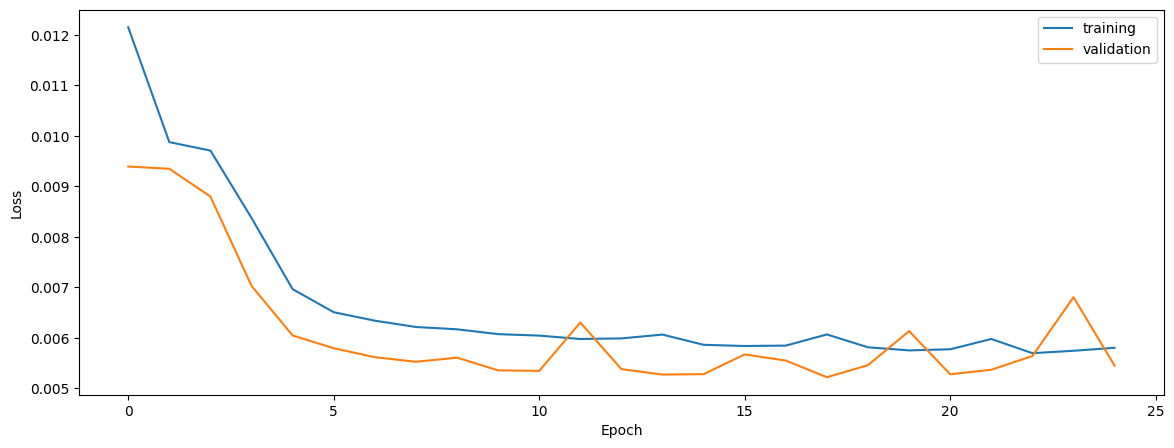

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.6478315413423347
0.6673411546627988
0.6366945724179358


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.6478315413423347
0.6673411546627988
0.6366945724179358


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.6528613769355491
0.67043769516736
0.6548484963781261


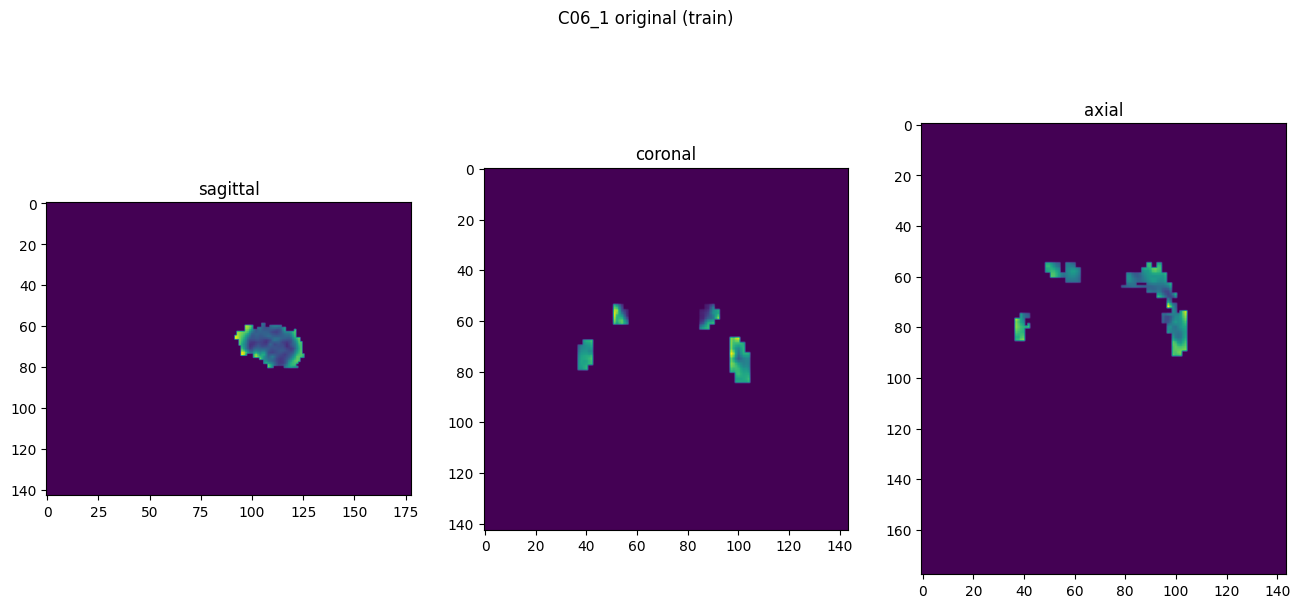

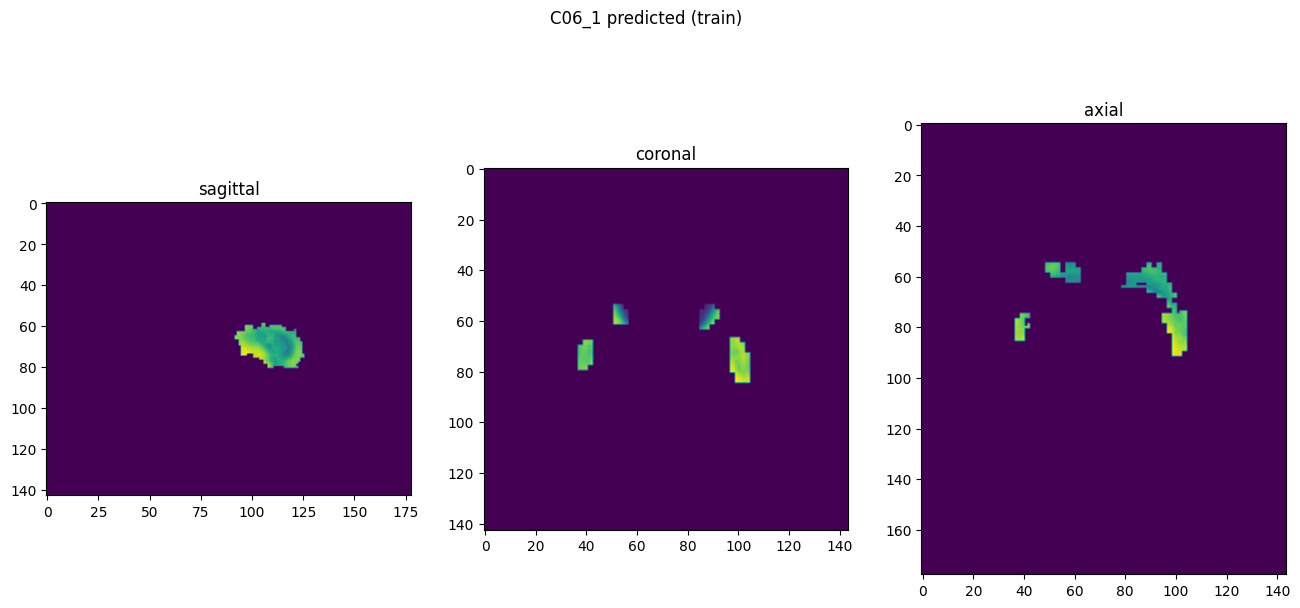

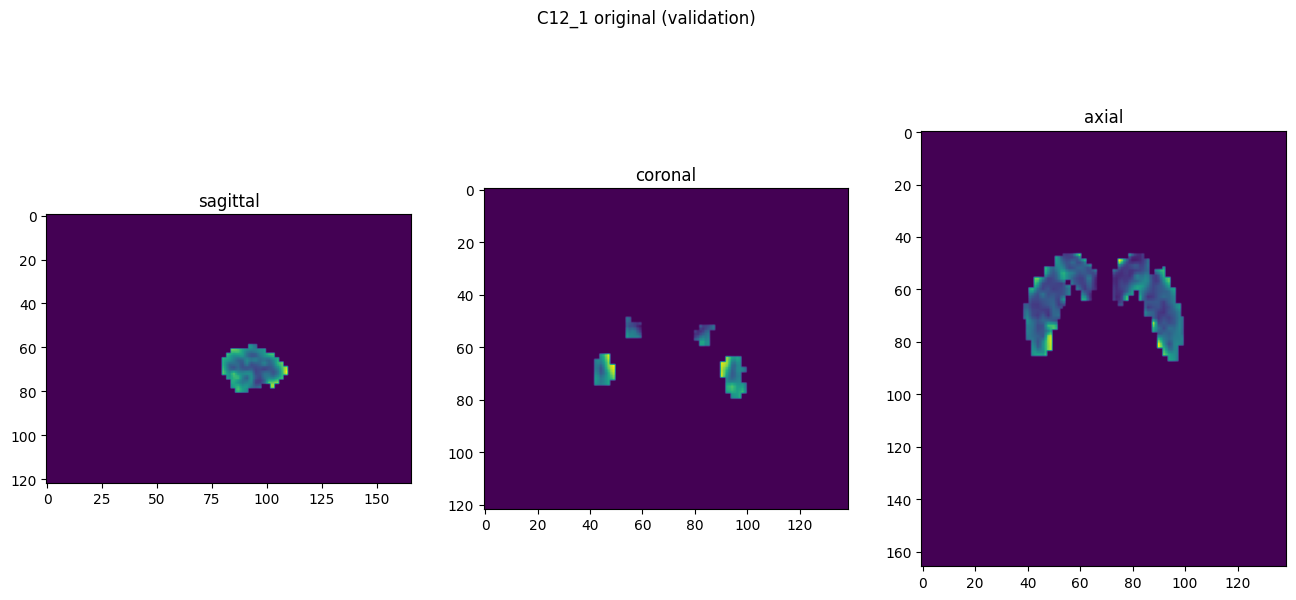

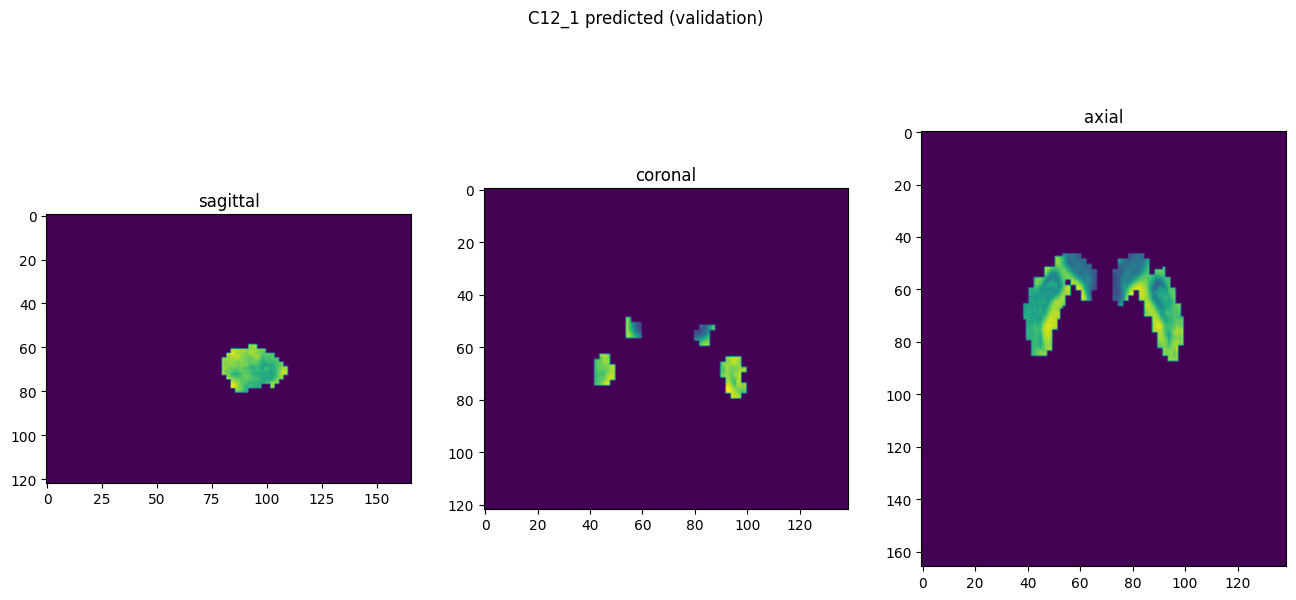

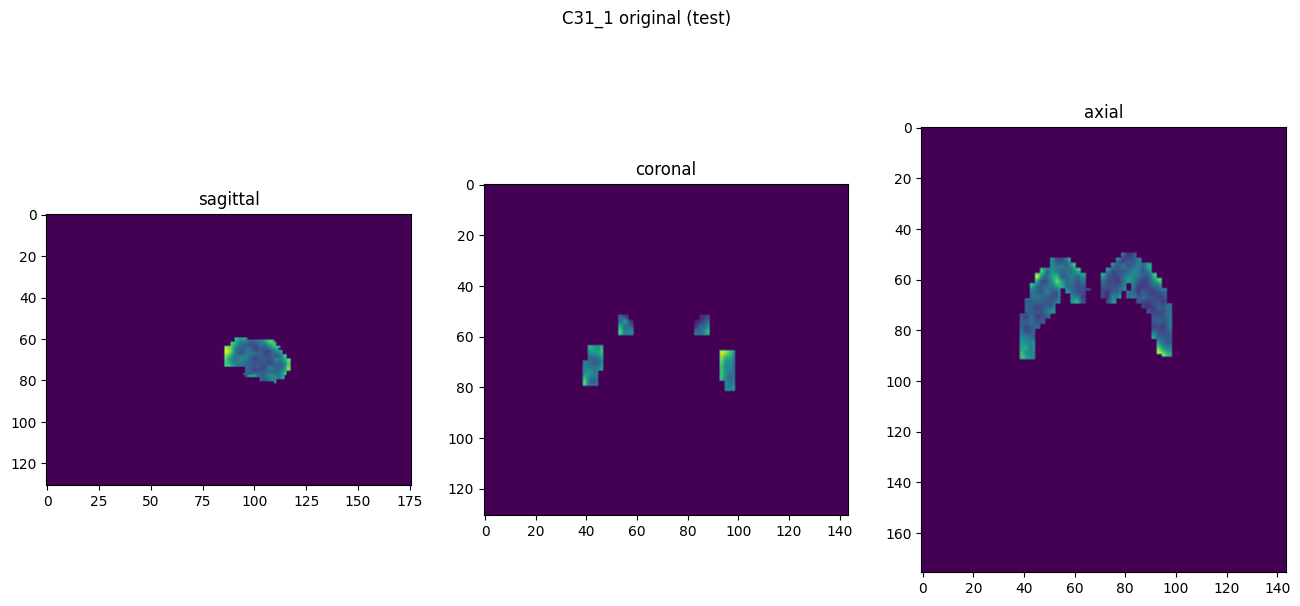

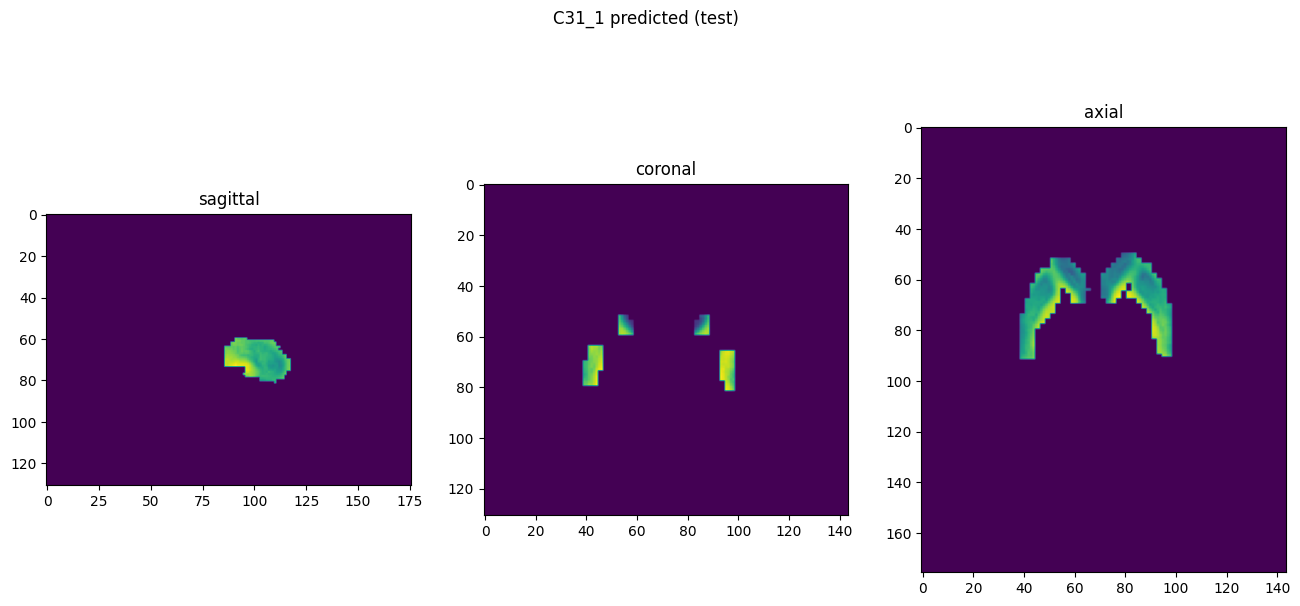

In [10]:
showResults(model, gen, threshold=None, background=False)